In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw2.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: [Lectures 2 and 3](https://ubc-cs.github.io/cpsc330-2025W1/README.html) 

**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html)**. 

Imports
------

In [2]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

<br><br>

**Important**: In this assignment, we are using an autograder so you can receive feedback on your solutions. For the autograder to work, you need to ensure that `otter-grader` is installed in the course environment. If you successfully installed the course environment, `otter-grader` should already be included. If not, you'll need to install it explicitly.

1. Go to the command line/terminal.
2. Activate the course conda environment and install otter-grader using the following commands.

    ```
    conda activate cpsc330
    pip install otter-grader
    ```

The cell at the top of the notebook will throw an error if you do not install `otter-grader`. Once you are done with the assignment follow the instructions below before the submission. 

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Instructions
rubric={points}

You will earn points for following these instructions and successfully submitting your work on Gradescope.  

- Please **read carefully
[Use of Generative AI policy](https://ubc-cs.github.io/cpsc330-2025W1/syllabus.html#use-of-generative-ai-in-the-course)** before starting the homework assignment. 
- **We are not allowing group submission for this homework assignment.**   

- **Run all cells before submitting:** Go to `Kernel -> Restart Kernel and Clear All Outputs`, then select `Run -> Run All Cells`. This ensures your notebook runs cleanly from start to finish without errors.
  
- **Submit your files on Gradescope.**  
   - Upload only your `.ipynb` file **with outputs displayed** and any required output files.
     
   - Do **not** submit other files from your repository.  
   - If you need help, see the [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/).  
- **Check that outputs render properly.**  
   - Make sure all plots and outputs appear in your submission.
     
   - If your `.ipynb` file is too large and doesn't render on Gradescope, also upload a PDF or HTML version so the TAs can view your work.  
- **Keep execution order clean.**  
   - Execution numbers must start at "1" and increase in order.
     
   - Notebooks without visible outputs may not be graded.  
   - Out-of-order or missing execution numbers may result in mark deductions.  
- **Follow course submission guidelines:** Review the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2025W1/docs/homework_instructions.html) for detailed guidance on completing and submitting assignments. 

   
</div>

_Points:_ 3

<!-- END QUESTION -->

<br><br>

<div class="alert alert-info">
    
## Warmup with toy dataset 

</div>

## Exercise 1: Terminology
rubric={autograde}

**Your Task:**

Please fill in each of the following sentences using the provided machine learning terminologies from the list below. Keep in mind that each term should be used only once!

**List of Terms (in no particular order):**

    a) hyperparameters
    b) training
    c) tree depth
    d) parameters
    e) example/data point
    f) features
    g) target
    h) root node
    i) branch
    j) leaf node

    

1. In the context of working with data, each individual row or instance, which includes both feature values and the corresponding target, is commonly referred to as an ________.

2. In supervise machine learning, the ________ is the variable we aim to predict or understand.

3. Before diving into the modeling process, it is necessary to define specific settings that impact the learning process; these settings are known as ________.

4. After the model has completed the training phase, it acquires specific values, such as which features to prioritize and the threshold for splitting them in the case of decision trees; these acquired values are referred to as _________.
   
5. In decision trees, the initial question we ask, which serves as the starting point, is commonly referred to as the ________.

6. The total number of steps or transitions from the initial question all the way to the final prediction in a decision tree is known as the ________.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 3

In [3]:
# format your answer like this: terminology = ['x','x','x','x','x','x']
terminology = ["e", "g", "a", "d", "h", "c"]

In [4]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<br><br><br><br>

## Exercise 2: Decision trees with a toy dataset 
<hr>

Suppose you have three different job offers with comparable salaries and job descriptions. You want to decide which one to accept, and you want to make this decision based on which job is likely to make you happy. Being a very systematic person, you come up with three features associated with the offers, which are important for your happiness: whether the colleagues are supportive, whether there is work-hour flexibility, and whether the company is a start-up or not. So the `X` of your offer data looks as follows: 

In [5]:
offer_data = {
    # Features
    "supportive_colleagues": [1, 0, 0, 1],
    "work_hour_flexibility": [0, 0, 1, 1],
    "start_up": [0, 1, 1, 1],    
}

offer_df = pd.DataFrame(offer_data)
offer_df

,supportive_colleagues,work_hour_flexibility,start_up
0,1,0,0
1,0,0,1
2,0,1,1
3,1,1,1


Your goal is to get predictions for these rows. In other words, for each row, you want to predict whether that job would make you **happy** or **unhappy**.   

So you ask the following questions to some of your friends (who you think have similar notions of happiness) regarding their jobs:

1. Do you have supportive colleagues? (1 for 'yes' and 0 for 'no')
2. Do you have flexible work hours? (1 for 'yes' and 0 for 'no')
3. Do you work for a start-up? (1 for 'start up' and 0 for 'non start up')
4. Are you happy in your job? (happy or unhappy)

Suppose you get the following data from this toy survey. You decide to train a machine learning model using this toy survey data and use this model to predict which job from `offer_df` is likely to make you happy. 

In [6]:
import pandas as pd

happiness_data = {
    # Features
    "supportive_colleagues": [1, 1, 1, 0, 0, 1, 1, 0, 1, 0],
    "work_hour_flexibility": [1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
    "start_up": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
    # Target
    "target": [
        "happy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "unhappy",
    ],
}

train_df = pd.DataFrame(happiness_data)
train_df

,supportive_colleagues,work_hour_flexibility,start_up,target
0,1,1,1,happy
1,1,1,0,happy
2,1,0,1,happy
3,0,1,0,unhappy
4,0,1,1,unhappy
5,1,0,0,happy
6,1,1,0,happy
7,0,0,1,unhappy
8,1,0,1,unhappy
9,0,0,0,unhappy


<br><br>

### 2.1 Decision stump by hand 
rubric={autograde}

**Your tasks:**

- With this toy dataset, build a decision stump (decision tree with only 1 split) manually, splitting on the condition `supportive_colleagues <= 0.5`. What training accuracy would you get with this decision stump? Save the accuracy as a decimal in an object named `supportive_colleagues_acc`. 

> You do not have to show any calculations or code. 

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [7]:
pred = ["unhappy" if sc <= 0.5 else "happy"
        for sc in train_df["supportive_colleagues"]]
supportive_colleagues_acc = (pd.Series(pred) == train_df["target"]).mean()

In [8]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<br><br>

### 2.2 Separating features and target
rubric={autograde}

Recall that in `scikit-learn`, before building a classifier, we need to separate features and target. 

**Your tasks:**

1. Separate features and target from `train_df` and save them in `X_train_toy` and `y_train_toy`, respectively. 

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 1

In [9]:
X_train_toy = train_df.drop(columns=["target"])
y_train_toy = train_df["target"]

In [10]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<br><br>

### 2.3 Create a decision tree classifier object
rubric={autograde}

**Your tasks:**

1. Create a `DecisionTreeClassifier` object with `random_state=16` and store it in a variable called `toy_tree`.

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 1

In [11]:
from sklearn.tree import DecisionTreeClassifier
toy_tree = DecisionTreeClassifier(random_state=16)

In [12]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<br><br>

### 2.4 `fit` the decision tree classifier 
rubric={autograde}

**Your tasks:**

1. Now train a decision tree model by calling `fit` on `toy_tree` with `X_train_toy` and `y_train_toy` created above. 

<div class="alert alert-warning">

Solution_2.4
    
</div>

_Points:_ 1

In [13]:
toy_tree.fit(X_train_toy, y_train_toy)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,16
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [14]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<br><br>

### 2.5 Visualize the trained decision tree
rubric={autograde}


**Your tasks:**
- Visualize the trained decision tree model using the [`tree.plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) method in `sklearn` by passing the appropriate values for the following arguments: 
    - `feature_names`
    - `class_names`
  
Save the names of the features in `feature_names` variable, names of the classes in `class_names` variable and the visualization tree returned by the function in a variable called `toy_tree_viz`.

<div class="alert alert-warning">

Solution_2.5
    
</div>

_Points:_ 2

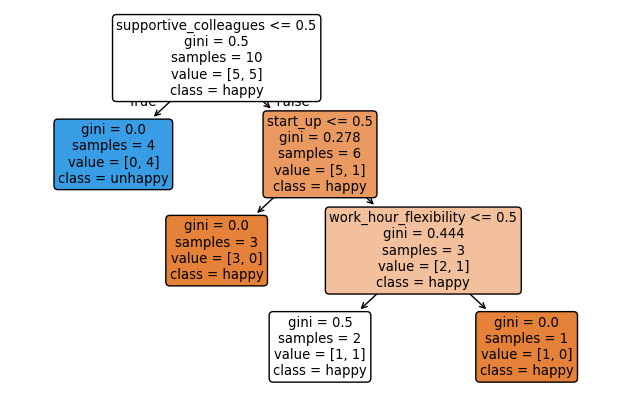

In [15]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

feature_names = X_train_toy.columns
class_names= [str(c) for c in sorted(y_train_toy.unique())]

plt.figure(figsize=(8, 5))
toy_tree_viz = tree.plot_tree(
    toy_tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True
)
plt.show()

In [16]:
grader.check("q2.5")

q2.5 results: All test cases passed!

<br><br>

### 2.6 Depth of the tree
rubric={autograde}

**Your tasks:**

1. What's the depth of the learned decision tree model? Save it as an integer in the variable `toy_depth` below. 

<div class="alert alert-warning">

Solution_2.6
    
</div>

_Points:_ 1

In [17]:
toy_depth = max_depth=3

In [18]:
grader.check("q2.6")

q2.6 results: All test cases passed!

<br><br>

### 2.7 Accuracy calculation
rubric={autograde}

**Your tasks:**

1. Evaluate the `toy_tree` on the training data (i.e., call `score()` on `X_train_toy` and `y_train_toy`) and store the score in a variable called `train_acc`.

<div class="alert alert-warning">

Solution_2.7
    
</div>

_Points:_ 1

In [19]:
train_acc = toy_tree.score(X_train_toy, y_train_toy)
train_acc

0.9

In [20]:
grader.check("q2.7")

q2.7 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 2.8 Discussion
rubric={reasoning}

**Your tasks:**

1. Do you achieve perfect training accuracy? If so, what are the reasons behind this, and if not, what factors contribute to the imperfection?

<div class="alert alert-warning">

Solution_2.8
    
</div>

_Points:_ 2

No, 0.9 training accuracy is not perfect which would be 1.0. This may be because the depth of the decision tree was not optimal. It would be more ideal if a cross validation error was calculated to determine the most optimal decision tree depth for improved training accuracy. 

Another reason for a non-perfect accuracy score could be contradictory lables where there are rows with almost identical features but differing targets. This means, no matter how the split occurs, the model can not classify both correctly leading to inevitable error. 

<!-- END QUESTION -->

<br><br>

### 2.9 Predicting on the offer data 
rubric={autograde}

**Your tasks:**

1. Using the trained decision tree above, predict the targets for all examples in `offer_df` and store them as a list in the `predictions` variable below.
2. In which jobs you are likely to be happy? Append the index or indices of all the examples where you are likely to be happy to the 'happy_job_indices' list below.

In [21]:
offer_df

,supportive_colleagues,work_hour_flexibility,start_up
0,1,0,0
1,0,0,1
2,0,1,1
3,1,1,1


<div class="alert alert-warning">

Solution_2.9
    
</div>

_Points:_ 3

In [22]:
predictions = toy_tree.predict(offer_df).tolist()
happy_job_indices = [i for i, y in enumerate(predictions) if y == "happy"]



In [23]:
grader.check("q2.9")

q2.9 results: All test cases passed!

<br><br>

<br><br><br><br>

<div class="alert alert-info">
    
## Apply on a Real Dataset

</div>

## Exercise 3: Decision trees on Spotify Song Attributes dataset 
<hr>

### Introducing the dataset
 
For the rest of the homework, you'll be using Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset. The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it under the `data` directory.

> You will not be able to push it to your repository (hopefully) because I have seeded the repository with `.gitignore`. 

### 3.1 Reading the data CSV
rubric={autograde}
 
**Your tasks:**
1. Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index.

> Make sure you have put the data CSV as `spotify.csv` under the data directory (data/spotify.csv). When you read the data file, use this relative path for the autograder to work properly on Gradescope. 

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 2

In [24]:
spotify_df =pd.read_csv("data/spotify.csv", index_col=0)

In [25]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<br><br>

### 3.2 Data splitting 
rubric={autograde}

**Your tasks:**

1. Split the dataframe into `train_df` and `test_df` with `random_state=123` and `test_size=0.2`. 


<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 2

In [26]:
from sklearn.model_selection import train_test_split 

train_df, test_df = train_test_split(
    spotify_df, test_size=0.2, random_state=123
)

In [27]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<br><br>

### 3.3 Number of training and test examples
rubric={autograde}

**Your tasks:**
1. How many training and test examples do we have? Store them as integers in the variables below. 

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 1

In [28]:
n_train_samples = len(train_df)
n_test_samples = len(test_df)

In [29]:
grader.check("q3.3")

q3.3 results: All test cases passed!

<br><br>

### 3.4 `describe` method 
rubric={autograde}

**Your tasks:**

1. Store the output of `describe()` **on the training split** in `spotify_summary` variable below and display the summary statistics. By default, this function will compute some summary statistics of the numeric columns.

> Note that `describe` returns another DataFrame.

<div class="alert alert-warning">

Solution_3.4
    
</div>

_Points:_ 2

In [30]:
spotify_summary = train_df.describe()

In [31]:
grader.check("q3.4")

q3.4 results: All test cases passed!

<br><br>

### 3.5 Largest range feature
rubric={autograde}

**Your tasks:**

1. Which feature has the largest range? Store the feature name as a string in the `largest_range_feature` variable below.

> Hint: You can subtract the min value from the max value of the column to get the range

> Remember that `range` is a built-in Python function, so avoid using it as a variable name.

<div class="alert alert-warning">

Solution_3.5
    
</div>

_Points:_ 2

In [32]:

numeric_df= spotify_df.select_dtypes(include="number")
range= numeric_df.max() - numeric_df.min()
largest_range_feature = range.idxmax()
largest_range_feature

'duration_ms'

In [33]:
grader.check("q3.5")

q3.5 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 3.6 Plotting histograms 
rubric={viz}

The starter code below produces histograms for the `loudness` feature using pandas plotting. The histograms show the distribution of the feature values in the training set, separated for positive (target=1, i.e., user liked the song) and negative (target=0, i.e., user disliked the song) examples. There are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

> Note: I am using `matplotlib` and pandas plotting here. If you decide to use other visualization libraries, they might not work on Gradescope because they won't be present in the environment file on Gradescope. 


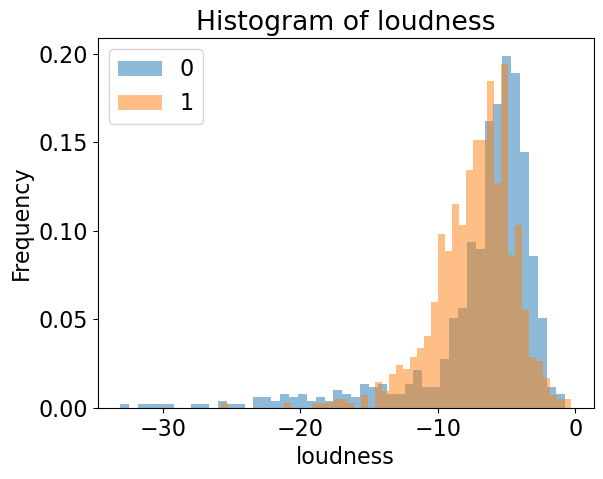

In [34]:
feat = "loudness"
train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat);
plt.xlabel(feat);

**Your tasks:**

Create histograms for the following features in the order below.
- acousticness
- danceability
- tempo
- energy
- valence

> To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of your loop, which draws the figure and resets the canvas for your next plot.

<div class="alert alert-warning">

Solution_3.6
    
</div>

_Points:_ 3

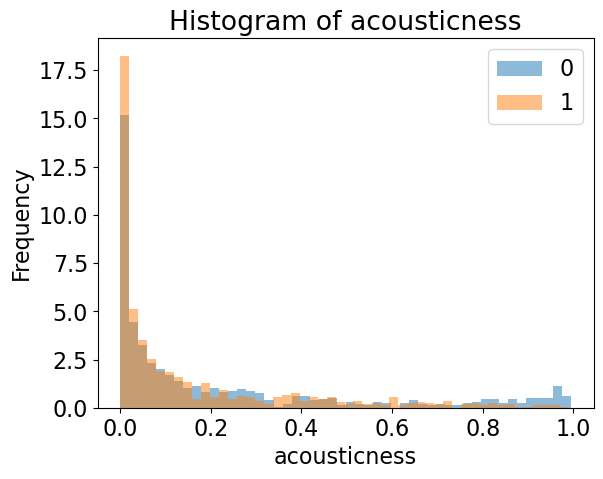

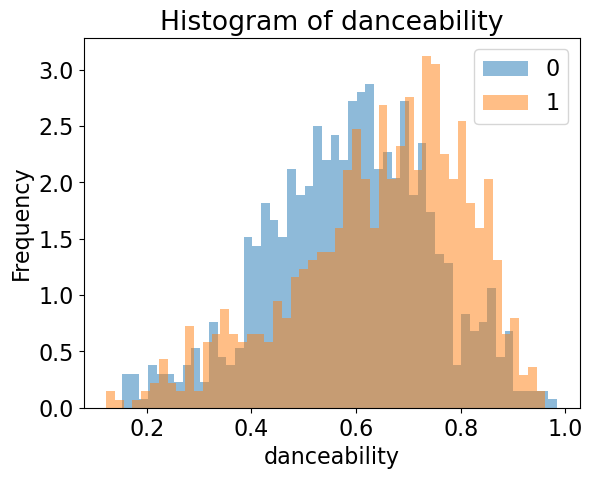

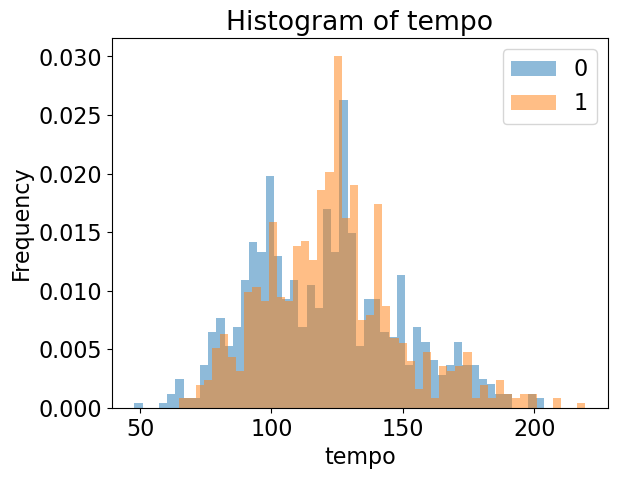

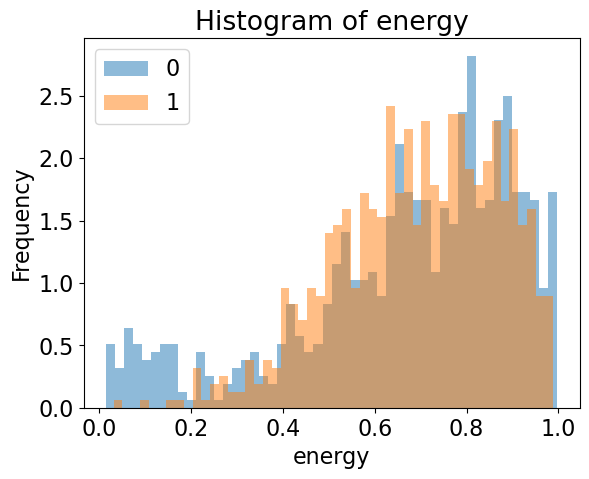

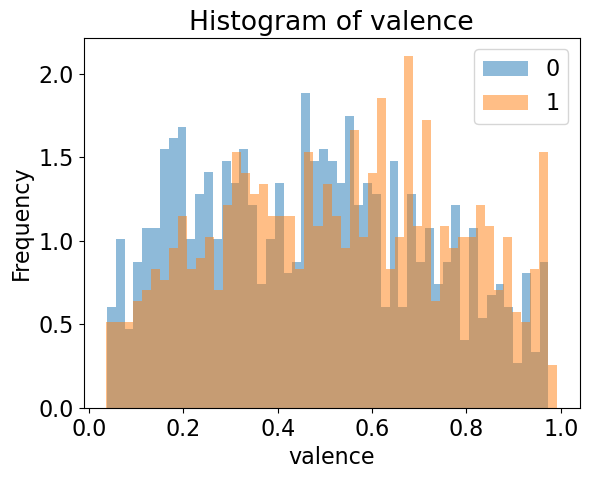

In [35]:
import matplotlib.pyplot as plt

features = ["acousticness", "danceability", "tempo", "energy", "valence"]

for feature in features:
    train_df.groupby("target")[feature].plot.hist(
        bins=50, alpha=0.5, legend=True, density=True
    )
    plt.xlabel(feature)
    plt.title(f"Histogram of {feature}")

    plt.show()

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.7 Identical histograms
rubric={reasoning}

**Your tasks:**

1. Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class? Briefly explain. 

<div class="alert alert-warning">

Solution_3.7
    
</div>

_Points:_ 2

No, this does not mean the features of identical histograms are not useful. It means that the features with identical histograms alone will not provide discriminatory power between classes because the distribution of values look the same regardless of the target. However, decision trees may pick up subtle patterns and differences even if the histograms may seem identical which would ultimately help classify the target.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.8 Which columns to include? 
rubric={reasoning}

Note that the dataset includes two text features labeled `song_title` and `artist`.

**Your tasks:**

1. Do you believe that these features could be valuable in predicting whether the user liked the song or not? If so, what makes them suitable, and if not, what makes them unsuitable?
2. Do you anticipate any challenges in using these features in their current form within your model? Please provide a brief explanation. 

<div class="alert alert-warning">

Solution_3.8
    
</div>

_Points:_ 3

I believe the artist feature will be the most valuable, since users often develop preferences for specific artists. If a user has liked songs by the same artist in the past, this increases the likelihood they will enjoy the new song as well. On the other hand, the song title is unlikely to be useful, as titles are often arbitrary and don’t provide meaningful information about the song’s characteristics or how much a user might like it.
2. If an artist produces a variety of types of music (ex: country, jazz, rap etc.) these are different styles which may not adhere to the same type of music that the user listens to. Therefore, it can be possible that the name of the artist is not a useful predictor in some cases. Similarly, the song title is unlikely to be useful in its raw form, since titles are often arbitrary, vary greatly in wording, and usually don’t contain meaningful information about the song’s actual characteristics. Without significant preprocessing or feature engineering, the song title will add little value to the model and may even introduce noise

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 4: Model building
<hr>

Now that we did some preliminary exploratory data analysis (EDA), let's move on to modeling. 

<br><br>

### 4.1 Creating `X` and `y`
rubric={autograde}

**Your tasks:**

1. Separate `X` and `y` from `train_df` and `test_df` from the previous exercise and store them as `X_train`, `y_train`, `X_test`, `y_test`, respectively. Skip the `song_title` and `artist` columns for now. 

<div class="alert alert-warning">

Solution_4.1
    
</div>

_Points:_ 2

In [36]:
X_train = train_df.drop(columns=["target", "song_title", "artist"])
y_train = train_df["target"]
X_test = test_df.drop(columns=["target", "song_title", "artist"])
y_test = test_df["target"]

In [37]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<br><br>

<br><br>

### 4.2 The baseline model: `DummyClassifier`
rubric={autograde}

**Your tasks:**
1. Carry out 10-fold cross-validation using `DummyClassifier` with `random_state=123`. Store the mean cross-validation score in the `dummy_score` variable below. 

<div class="alert alert-warning">

Solution_4.2
    
</div>

_Points:_ 1

In [38]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

dummy_clf= DummyClassifier(random_state=123)
scores=cross_val_score(dummy_clf, X_train, y_train, cv=10)
dummy_score = np.mean(scores) 

In [39]:
grader.check("q4.2")

q4.2 results: All test cases passed!

<br><br>

### 4.3 Creating a Decision Tree model
rubric={autograde}

**Your tasks:**

1. Create a `DecisionTreeClassifier` with `random_state=123` and store it in a variable called `spotify_tree`.

<div class="alert alert-warning">

Solution_4.3
    
</div>

_Points:_ 1

In [40]:
from sklearn.tree import DecisionTreeClassifier
spotify_tree = DecisionTreeClassifier(random_state=123)

In [41]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<br><br>

### 4.4 Cross-validation with `DecisionTreeClassifier`
rubric={autograde}

**Your tasks:** 

1. Carry out 10-fold cross validation with the `spotify_tree` object above using `cross_validate` on `X_train` and `y_train`. Pass `return_train_score=True` to `cross_validate`. Save the results as a pandas dataframe in a variable called `dt_scores_df`. 

<div class="alert alert-warning">

Solution_4.4
    
</div>

_Points:_ 4

In [42]:
spotify_tree = DecisionTreeClassifier(random_state=123)

dt_scores = cross_validate(
    spotify_tree,
    X_train,
    y_train,
    cv=10,                   
    return_train_score=True, 
)

dt_scores_df = pd.DataFrame(dt_scores)

dt_scores_df

,fit_time,score_time,test_score,train_score
0,0.010715,0.000738,0.697531,0.999311
1,0.010903,0.000654,0.660494,1.000000
2,0.009921,0.000595,0.685185,0.999311
3,0.010494,0.000604,0.639752,1.000000
4,0.009753,0.000539,0.639752,0.999311
5,0.009636,0.000514,0.658385,0.999311
6,0.009701,0.000525,0.639752,0.999311
7,0.010557,0.000528,0.590062,0.999311
8,0.010058,0.000537,0.701863,0.999311
9,0.010180,0.000544,0.695652,0.999311


In [43]:
grader.check("q4.4")

q4.4 results:
    q4.4 - 1 result:
        ✅ Test case passed

    q4.4 - 2 result:
        ✅ Test case passed

    q4.4 - 3 result:
        ❌ Test case failed
        Trying:
            assert np.isclose(round(dt_scores_df['test_score'].mean(), 3), 0.671), 'Your test scores are incorrect'
        Expecting nothing
        **********************************************************************
        Line 1, in q4.4 2
        Failed example:
            assert np.isclose(round(dt_scores_df['test_score'].mean(), 3), 0.671), 'Your test scores are incorrect'
        Exception raised:
            Traceback (most recent call last):
              File "/Users/arisak/miniforge3/envs/cpsc330/lib/python3.13/doctest.py", line 1395, in __run
                exec(compile(example.source, filename, "single",
                ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                             compileflags, True), test.globs)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "<doctest q4.4 2[0]>", line 1, in <module>
                assert np.isclose(round(dt_scores_df['test_score'].mean(), 3), 0.671), 'Your test scores are incorrect'
                       ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: Your test scores are incorrect
        Trying:
            assert np.isclose(round(dt_scores_df['train_score'].mean(), 3), 0.999), 'Your train scores are incorrect'
        Expecting nothing
        ok

<br><br>

<!-- BEGIN QUESTION -->

### 4.5 Examining cross-validation scores
rubric={reasoning}

**Your tasks:** 
1. Inspect the 10 sub-scores from the 10 folds of cross-validation. To what extent do you trust the numerical value / precision of the cross validation score? Briefly explain.  
2. Do you see a significant difference between the training scores and the cross-validation scores? Briefly discuss in 1 to 2 sentences. 

<div class="alert alert-warning">

Solution_4.5
    
</div>

_Points:_ 4

1.I would only trust the cross-validation score as a rough estimate of model performance. The 10 fold test scores vary noticeably (e.g., 0.59 to 0.70), so the mean score is not precise to multiple decimal places. It reflects the general range of performance but comes with uncertainty due to fold-to-fold variation.

2.Yes, there is a significant difference. The training scores are consistently close to 1.0, while the cross-validation scores are much lower (~0.65), which suggests the model is overfitting — it memorizes training data well but does not generalize as effectively to unseen data.

In [44]:
dt_scores_df.mean()

fit_time       0.010192
score_time     0.000578
test_score     0.660843
train_score    0.999449
dtype: float64

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 5: Hyperparameters
<hr>

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

### 5.1 Train and cross-validation accuracies 
rubric={autograde}


**Your tasks:**

1. Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with the following values of `max_depth`: `np.arange(1, 25, 2)`. Set the `random_state` of `DecisionTreeClassifier` to 123 in each case for reproducibility. 
2. For each `max_depth`, get both the mean train accuracy and the mean cross-validation accuracy. Store your results in the `results_df` dataframe, where the max_depth is set as the index. 

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 1") if you do so.

In [45]:
depths = np.arange(1, 25, 2)
depths

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])

<div class="alert alert-warning">

Solution_5.1
    
</div>

_Points:_ 6

In [46]:
results_dict = {"max_depth": [], "mean_train_score": [], "mean_cv_score": []}

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=123)
    scores = cross_validate(tree, X_train, y_train, cv=10, return_train_score=True)
    
    results_dict["max_depth"].append(d)
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))

    results_df = pd.DataFrame(results_dict).set_index("max_depth")


In [47]:
results_df

,mean_train_score,mean_cv_score
max_depth,,
1,0.651030,0.646032
3,0.733485,0.692524
5,0.794035,0.711713
7,0.858718,0.703677
9,0.912930,0.690610
11,0.954882,0.684392
13,0.981057,0.675700
15,0.993525,0.658979
17,0.998278,0.666433


In [48]:
results_df.shape

(12, 2)

In [49]:
grader.check("q5.1")

q5.1 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 5.2 Visualization 
rubric={viz}

1. Make a plot with `max_depth` on the *x*-axis and the train and cross-validation accuracies on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. 

**Ensure your plot includes the following:**

1. Both the train accuracy and the cross-validation accuracy are included in the plot.
2. Include a legend to specify which is which. 
3. The provided `max_depth` values are used.
4. The x-axis and y-axis have reasonable names.
5. The data points are correct.

<div class="alert alert-warning">

Solution_5.2
    
</div>

_Points:_ 5

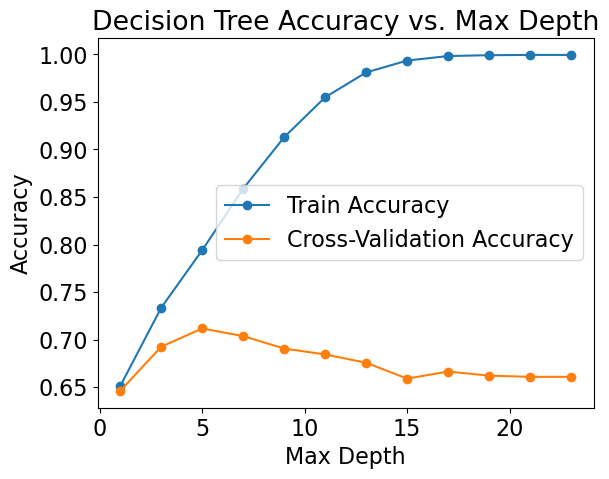

In [50]:
plt.plot(results_df.index, results_df["mean_train_score"], marker="o", label="Train Accuracy")
plt.plot(results_df.index, results_df["mean_cv_score"], marker="o", label="Cross-Validation Accuracy")

plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs. Max Depth")

plt.legend()

plt.show()

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.3 `max_depth` and the fundamental tradeoff
rubric={reasoning}

**Your tasks:**
1. Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. 

<div class="alert alert-warning">

Solution_5.3
    
</div>

_Points:_ 2

As max_depth increases, the decision tree becomes more complex, meaning it can fit the training data more closely. This leads to higher training accuracy but risks overfitting, where the model memorizes the training data instead of generalizing. Conversely, small max_depth values underfit the data, leading to lower training and validation accuracy. The fundamental tradeoff is between bias (too simple, underfitting) and variance (too complex, overfitting). Cross-validation helps us find the max_depth where this balance is optimal.

<!-- END QUESTION -->

<br><br>

### 5.4 Picking the "best" value for `max_depth`
rubric={autograde}

**Your tasks:**
1. From these results, pick the "best" `max_depth`, the one which gives the maximum cross-validation score. Store it in a variable called `best_max_depth` as an integer. 

<div class="alert alert-warning">

Solution_5.4
    
</div>

_Points:_ 1

In [51]:
best_max_depth = results_df["mean_cv_score"].idxmax()
best_max_depth

np.int64(5)

In [52]:
grader.check("q5.4")

q5.4 results: All test cases passed!

<br><br><br><br>

## Exercise 6: Final assessment
<hr>

Now that we have our finalized model, we are ready to evaluate it on the test set. 

### 6.1 Final assessment on the test split 
rubric={autograde}



**Your tasks:**

1. Create a decision tree model `best_model` using the `best_max_depth` you chose in the previous exercise with `random_state=123`. 
2. Fit the `best_model` on the _entire training set_ (`X_train` and `y_train`). 
2. Compute the test score (on `X_test` and `y_test`) and store it in a variable called `test_score` below. 

<div class="alert alert-warning">

Solution_6.1
    
</div>

_Points:_ 3

In [53]:
best_model = DecisionTreeClassifier(max_depth=best_max_depth, random_state=123)
best_model.fit(X_train, y_train)

test_score = best_model.score(X_test, y_test)
test_score

0.7178217821782178

<br><br>

<!-- BEGIN QUESTION -->

### 6.2 Analysis
rubric={reasoning}

**Your tasks:**

1. How do the test scores compare to the cross-validation scores? Briefly discuss. 
2. Why can't you simply pick the value of `max_depth` that gives the best accuracy on the training data? (Answer in maximum 2 to 3 sentences.)
3. Do you think that the `max_depth` you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

<div class="alert alert-warning">

Solution_6.2
    
</div>

_Points:_ 4

1. The test score of 0.7178 is very close to the mean cross-validation score. This suggests that the cross-validation procedure provided a reliable estimate of model performance, and the model is not severely overfitting or underfitting.
2. Training accuracy measures memorization, not generalization. If we picked the max_depth with the best training accuracy, it would always be the largest depth, which causes overfitting. The model would achieve near-perfect performance on training but much lower scores on validation/test sets. Cross-validation avoids this problem by estimating performance on unseen data.
3. Since the cross-validation and test scores align closely (both around ~0.72), it’s reasonable to expect the chosen max_depth to generalize to similar Spotify datasets. However, user listening preferences can vary, so while the model should transfer fairly well, retraining and validating on new data would still be necessary for best performance.Since the cross-validation and test scores align closely (both around ~0.72), it’s reasonable to expect the chosen max_depth to generalize to similar Spotify datasets. However, user listening preferences can vary, so while the model should transfer fairly well, retraining and validating on new data would still be necessary for best performance.

<!-- END QUESTION -->

<br><br><br><br>

Before submitting your assignment, please make sure you have followed all the instructions in the Submission Instructions section at the top. 

Here is a quick checklist before submitting: 

- [ ] Restart kernel, clear outputs, and run all cells from top to bottom.  
- [ ] `.ipynb` file runs without errors and contains all outputs.  
- [ ] Only `.ipynb` and required output files are uploaded (no extra files).  
- [ ] Execution numbers start at **1** and are in order.  
- [ ] If `.ipynb` is too large and doesn't render on Gradescope, also upload a PDF/HTML version.  
- [ ] Reviewed the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2025W1/docs/homework_instructions.html).  

Before submitting your assignment, please make sure you have followed all the instructions in the Submission Instructions section at the top. 

Congratulations on working with your first machine learning model! Well done 👏👏!

![](img/eva-well-done.png)